<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/example%20ICA%20for%20Fetal%20ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import os, subprocess
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA
import time
from sklearn.preprocessing import StandardScaler

# Load data

## Example 1

In [2]:
# Load the two-channel abdominal ECG recordings
abdominal_ecg_data = np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami3a.txt')
abdominal_ecg_data1 = np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami3b.txt')

# Extract the relevant signal columns (assuming column 1)
abdominal_signal_1 = abdominal_ecg_data[:, 1]
abdominal_signal_2 = abdominal_ecg_data1[:, 1]

# Load the reference direct fetal ECG recording
fetal_ecg_data = np.loadtxt('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ecg-aami4a.txt')
# Extract the relevant signal column (assuming column 1)
fetal_signal_direct = fetal_ecg_data[:, 1]

# Define sampling frequency (adjust if different)
Fs = 720  # Hz

## Example 2

In [3]:
!pip install mne --quiet
!pip install wfdb --quiet


In [5]:
import mne, wfdb

In [6]:
# https://physionet.org/content/adfecgdb/1.0.0/
base = "https://physionet.org/files/adfecgdb/1.0.0"

for edf in ["r01.edf"]:          # pick files you like
    if not os.path.isfile(edf):
        !wget -q -c {base}/{edf}            # Colab magic !wget
        print(f"downloaded → {edf}")

# ----------------------------------------------------------
# 2.  load with MNE → numpy arrays
# ----------------------------------------------------------
raw_ECG_EDF = mne.io.read_raw_edf("r01.edf", preload=True)

Extracting EDF parameters from /content/r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...


In [7]:
# shape of initial ECG array
np.shape(raw_ECG_EDF.get_data())

(5, 300000)

In [8]:
raw_ECG_EDF.info

<Info | 8 non-empty values
 bads: []
 ch_names: Direct_1, Abdomen_1, Abdomen_2, Abdomen_3, Abdomen_4
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 150.0 Hz
 meas_date: 2011-01-01 00:00:00 UTC
 nchan: 5
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: r01, sex: 2, last_name: X>
>

In [9]:
#chanels name
raw_ECG_EDF.ch_names

['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']

In [23]:
Fs = int(raw_ECG_EDF.info['sfreq'])               # 1000 Hz in this DB
abdominal_ecg_data1  = raw_ECG_EDF.get_data(picks ='Abdomen_1').squeeze()
abdominal_ecg_data2  = raw_ECG_EDF.get_data(picks='Abdomen_4').squeeze()
fetal_ecg_data       = raw_ECG_EDF.get_data(picks='Direct_1').squeeze()


In [26]:

# equalise lengths
n_min = min(len(abdominal_ecg_data1), len(abdominal_ecg_data2), len(fetal_ecg_data))
n_min = 1900
abdominal_ecg_data1  = abdominal_ecg_data1[:n_min]
abdominal_ecg_data2 = abdominal_ecg_data2[:n_min]
fetal_ecg_data      = fetal_ecg_data     [:n_min]


#ICA algorithm

In [54]:
# --- Prepare Data for ICA ---
# Combine the abdominal ECG channels into a single array for ICA
# Rows are observations (channels), columns are time points (samples)
X_mixed = np.vstack((abdominal_ecg_data1, abdominal_ecg_data2, fetal_ecg_data)) # Shape (3, N)

# Transpose so that rows are samples and columns are signals (channels)
# This is the typical input format for many ICA implementations
X_mixed = X_mixed.T # Shape (N, 3)

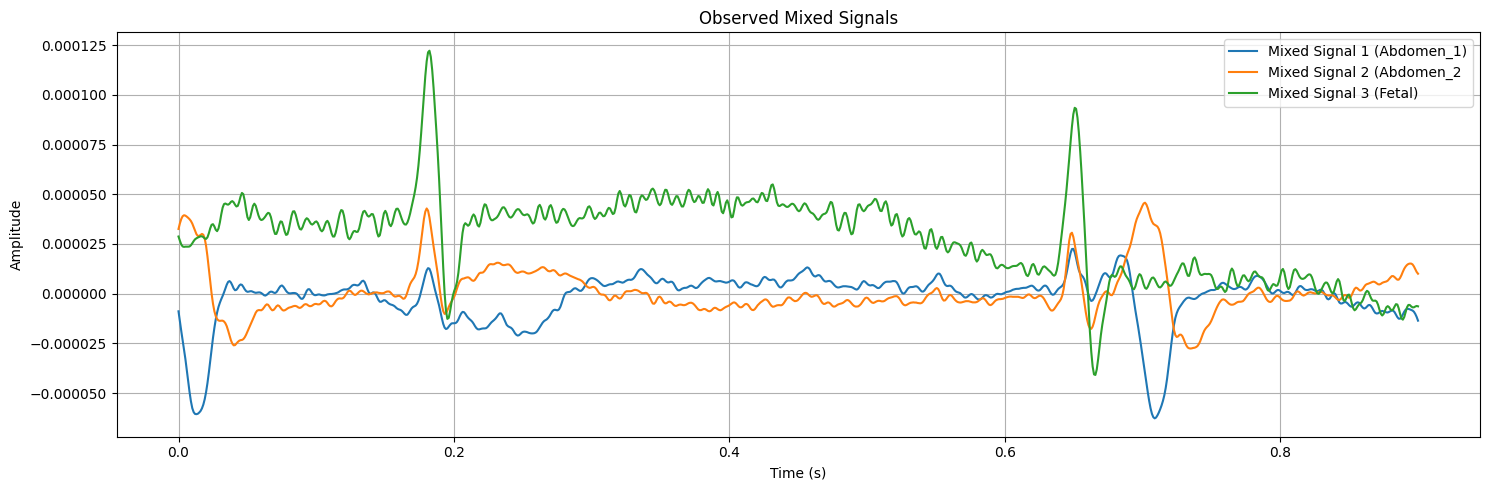

In [55]:
# Determine time axis length (assuming all signals are the same length)
n_samples = len(abdominal_ecg_data1)
duration_seconds = n_samples / Fs
time_axis = np.linspace(0, duration_seconds, n_samples)

# Plotting the mixed signals with a legend
plt.figure(figsize=(15, 5))
plt.plot(time_axis, X_mixed[:, 0], label='Mixed Signal 1 (Abdomen_1)')
plt.plot(time_axis, X_mixed[:, 1], label='Mixed Signal 2 (Abdomen_2 ')
plt.plot(time_axis, X_mixed[:, 2], label='Mixed Signal 3 (Fetal)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Observed Mixed Signals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
 scaler = StandardScaler()
 X_mixed = scaler.fit_transform(X_mixed)

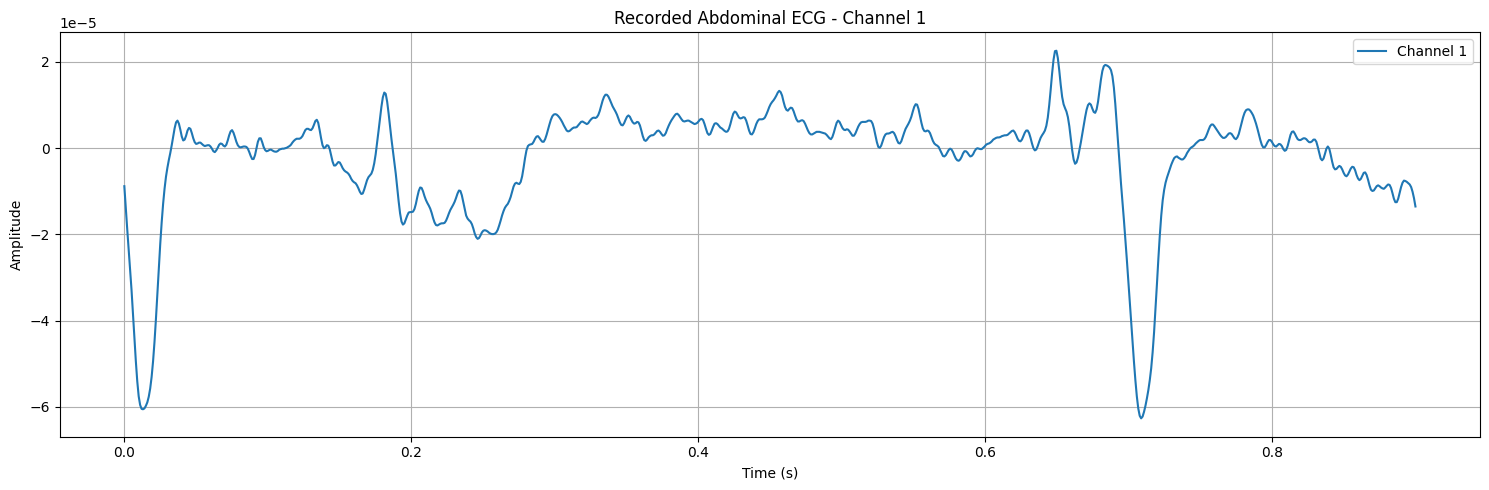

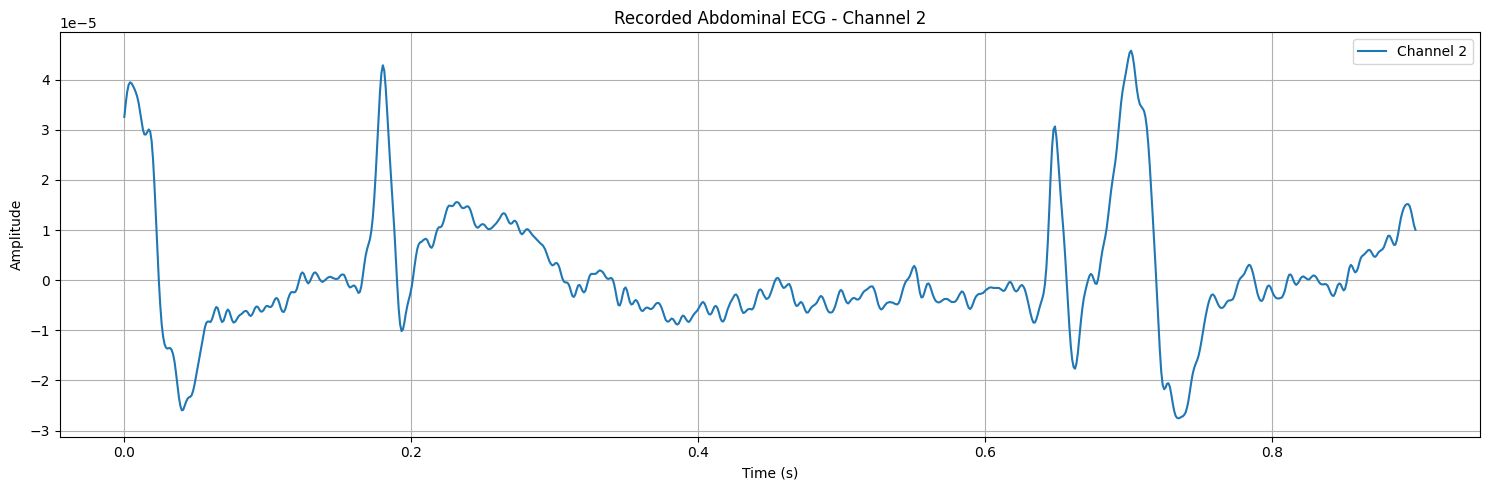

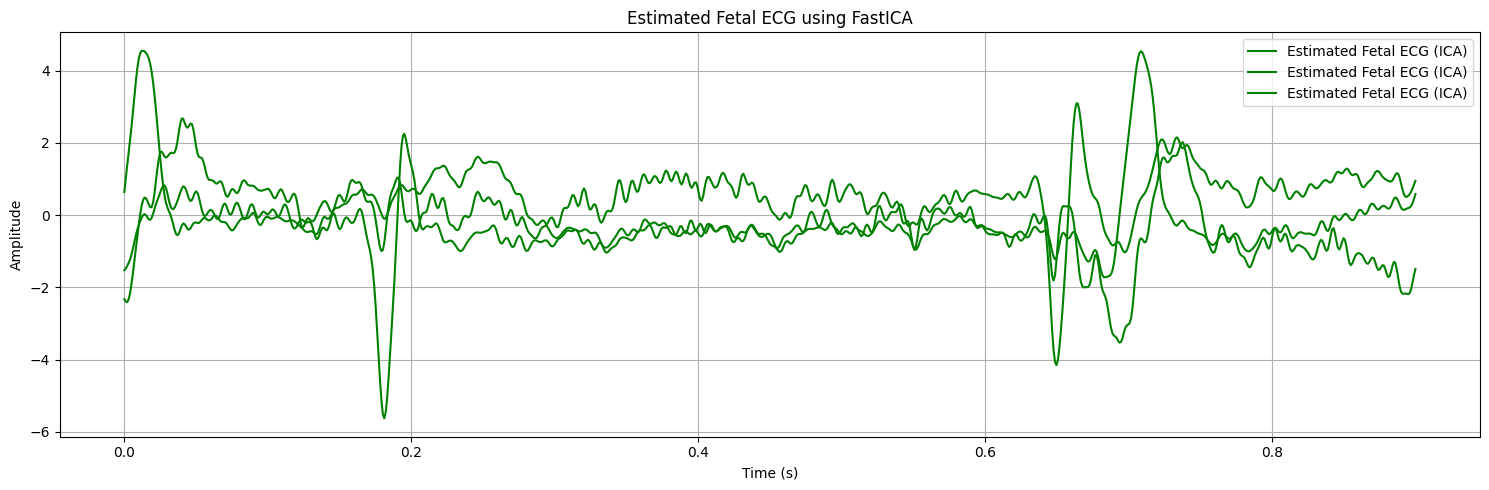

Estimated Mixing Matrix A_ica (Channel Contributions to Source):
 [[-0.34769369 -0.65365166 -1.00628622]
 [-0.64836794 -1.02266073  0.04531375]
 [-0.70024075  0.78735694  0.20025019]]

Estimated Components Matrix W_ica (Weights for Source Extraction):
 [[-0.34769369 -0.64836794 -0.70024075]
 [-0.65365166 -1.02266073  0.78735694]
 [-1.00628622  0.04531375  0.20025019]]

--- ICA Process Explanation for Fetal ECG Extraction ---
1. Data Loaded:
   - Abdominal ECG Channel 1: 900 samples
   - Abdominal ECG Channel 2: 900 samples
   - Sampling Frequency (Fs): 1000 Hz
   - Duration: ~0.90 seconds

2. Data Preparation:
   - Mixed signals (X_mixed) arranged as an array of shape (900, 3).
     - Rows represent time points.
     - Columns represent the recorded abdominal ECG channels.

3. FastICA Application:
   - FastICA configured to find n_components=1 source.
   - Assumes the underlying sources are statistically independent.
   - Applies a whitening step internally to decorrelate and normalize

In [57]:
# --- Apply FastICA ---
# Create the FastICA object.
# We expect 1 component (the fetal ECG).
# `whiten='unit-variance'` is a common choice.
# `random_state` ensures reproducibility.
# `fun='logcosh'` is the default and generally good nonlinear function.
# `max_iter=200` increases iterations if needed (default is 200).

transformer = FastICA(
    n_components=3,
    #whiten='unit-variance',
    fun='logcosh', # You can try 'exp' or 'cube' as well
    random_state=37, # For reproducible results
    max_iter=500 # Increase if convergence warning occurs
)


# Fit the ICA model to the mixed data and transform it to get the sources
# S_ica will contain the estimated independent components (sources)
# Note: FastICA usually returns sources as (n_components, n_samples) or (n_samples, n_components)
# Sklearn's FastICA.fit_transform returns (n_samples, n_components)
S_ica_sources = transformer.fit_transform(X_mixed) # Shape (N, 1)
# Mixing matrix A_ica
A_ica_mixing = transformer.components_.T # Shape (n_features, n_components)
# Components matrix W_ica (unmixing/transforming matrix)
W_ica_components = transformer.components_ # Shape (n_components, n_channels) -> (1, 2)


# --- Select the Estimated Fetal ECG Source ---
# Sklearn's fit_transform gives us the sources.
# S_ica_sources shape is (N, n_components=1)
# We squeeze to remove the singleton dimension, resulting in (N,)
S_ica_estimated = S_ica_sources.squeeze() # Shape (N,)

# --- Visualization ---

# Plot Abdominal ECG Channel 1
plt.figure(figsize=(15, 5))
plt.plot(time_axis, abdominal_ecg_data1, label='Channel 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Recorded Abdominal ECG - Channel 1')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Abdominal ECG Channel 2
plt.figure(figsize=(15, 5))
plt.plot(time_axis, abdominal_ecg_data2, label='Channel 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Recorded Abdominal ECG - Channel 2')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Estimated Fetal ECG (ICA Output)
plt.figure(figsize=(15, 5))
plt.plot(time_axis, S_ica_estimated, label='Estimated Fetal ECG (ICA)', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Estimated Fetal ECG using FastICA')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Direct Fetal ECG Reference (if available and length matches)
if len(fetal_signal_direct) == n_samples:
    plt.figure(figsize=(15, 5))
    plt.plot(time_axis, fetal_ecg_data, label='Direct Fetal ECG (Reference)', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Direct Fetal ECG Recording (Reference)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Warning: Length mismatch. Abdominal ECG: {n_samples}, Direct Fetal ECG: {len(fetal_signal_direct)}. Skipping direct fetal plot.")

# Optional: Plot the mixing matrix
print("Estimated Mixing Matrix A_ica (Channel Contributions to Source):\n", A_ica_mixing)
# Optional: Plot the components matrix (weights used for transformation)
print("\nEstimated Components Matrix W_ica (Weights for Source Extraction):\n", W_ica_components)

# --- Explanation of ICA Process for Fetal ECG ---

print("\n--- ICA Process Explanation for Fetal ECG Extraction ---")
print(f"1. Data Loaded:")
print(f"   - Abdominal ECG Channel 1: {len(abdominal_ecg_data1)} samples")
print(f"   - Abdominal ECG Channel 2: {len(abdominal_ecg_data2)} samples")
print(f"   - Sampling Frequency (Fs): {Fs} Hz")
print(f"   - Duration: ~{duration_seconds:.2f} seconds")

print(f"\n2. Data Preparation:")
print(f"   - Mixed signals (X_mixed) arranged as an array of shape {X_mixed.shape}.")
print(f"     - Rows represent time points.")
print(f"     - Columns represent the recorded abdominal ECG channels.")

print(f"\n3. FastICA Application:")
print(f"   - FastICA configured to find n_components=1 source.")
print(f"   - Assumes the underlying sources are statistically independent.")
print(f"   - Applies a whitening step internally to decorrelate and normalize the input signals.")
print(f"   - Uses the 'logcosh' nonlinear function (contrast function) to maximize non-Gaussianity.")
print(f"   - Finds an unmixing matrix (W_ica_components) to transform the mixed data.")

print(f"\n4. Source Estimation:")
print(f"   - The transformation S_ica_sources = X_mixed @ W_ica_components yields the estimated sources.")
print(f"   - Shape of estimated sources before squeezing: {S_ica_sources.shape}")
print(f"   - Shape of final estimated fetal ECG (S_ica_estimated): ({len(S_ica_estimated)},)")
print(f"   - This represents the 1 independent component extracted by ICA.")

print(f"\n5. Results:")
print(f"   - The estimated fetal ECG signal is plotted.")
print(f"   - If lengths match, the direct fetal ECG reference is also plotted for comparison.")
print(f"   - The mixing matrix A_ica shows how much each abdominal channel contributed to the estimated source.")
print(f"   - The goal is for one of the extracted components to resemble the direct fetal ECG reference.")

print(f"\n--- Key Concepts ---")
print(f"- Non-Gaussianity Maximization: ICA works because the maternal ECG, fetal ECG, and noise tend to be more Gaussian than their independent mixture. By maximizing non-Gaussianity, ICA finds directions in the data that correspond to these potentially non-Gaussian sources.")
print(f"- Whitening: This preprocessing step makes the mixed signals uncorrelated and have unit variance, simplifying the ICA problem.")
print(f"- Contrast Function ('logcosh'): This function helps measure and maximize the non-Gaussianity of the estimated components. Different functions (like 'exp' or 'cube') can be tried depending on the data characteristics.")
print(f"- Number of Components: Here, we explicitly asked for 1 component, hoping it would be the fetal ECG. In practice, extracting multiple components and identifying the fetal ECG one post-hoc might be necessary.")
print(f"- Ambiguity: ICA cannot determine the original order or scale of the sources. The extracted signal might need scaling or inversion to match the reference.")


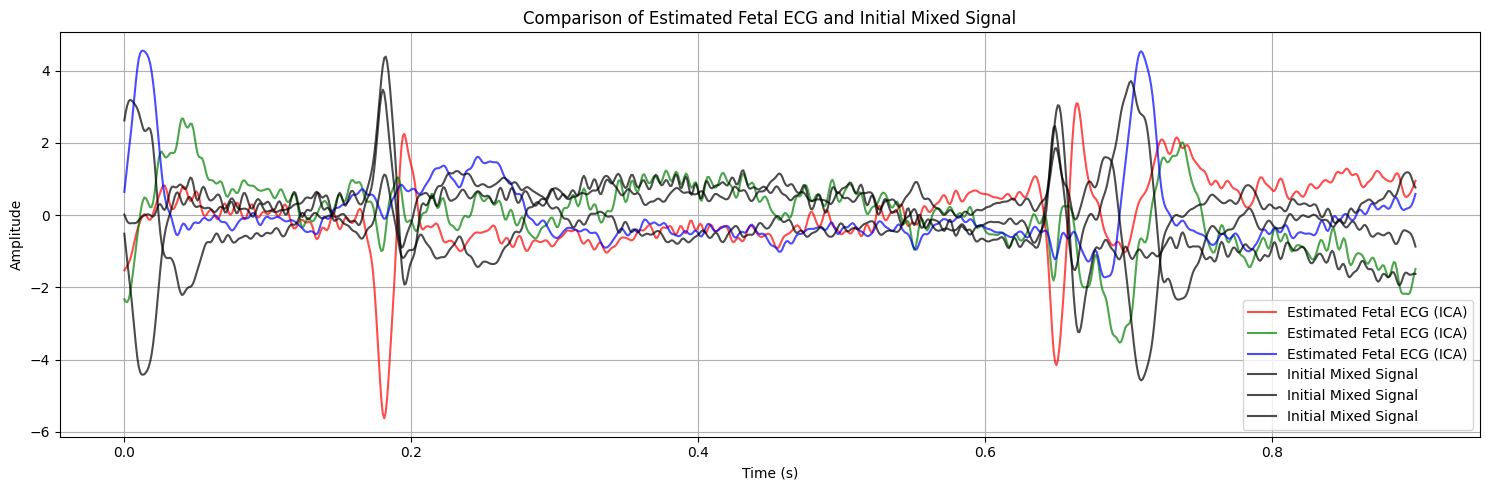

In [59]:
# Plot the estimated ICA source and an initial mixed signal for comparison

plt.figure(figsize=(15, 5))

# Plot estimated ICA source
plt.plot(time_axis, S_ica_estimated[:,0], label='Estimated Fetal ECG (ICA)', color='red', alpha=0.7) # Changed color to red
plt.plot(time_axis, S_ica_estimated[:,1], label='Estimated Fetal ECG (ICA)', color='green', alpha=0.7) # Changed color to red
plt.plot(time_axis, S_ica_estimated[:,2], label='Estimated Fetal ECG (ICA)', color='blue', alpha=0.7) # Changed color to red

# Plot one of the initial mixed signals (e.g., Abdomen_1)
# You can change the index [:, 0] to [:, 1] or [:, 2] to plot a different mixed signal
plt.plot(time_axis, X_mixed, label='Initial Mixed Signal', color='black', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Comparison of Estimated Fetal ECG and Initial Mixed Signal')
plt.grid(True)
plt.legend() # Add legend to distinguish the two lines
plt.tight_layout()
plt.show()

# Verify how FastICA works

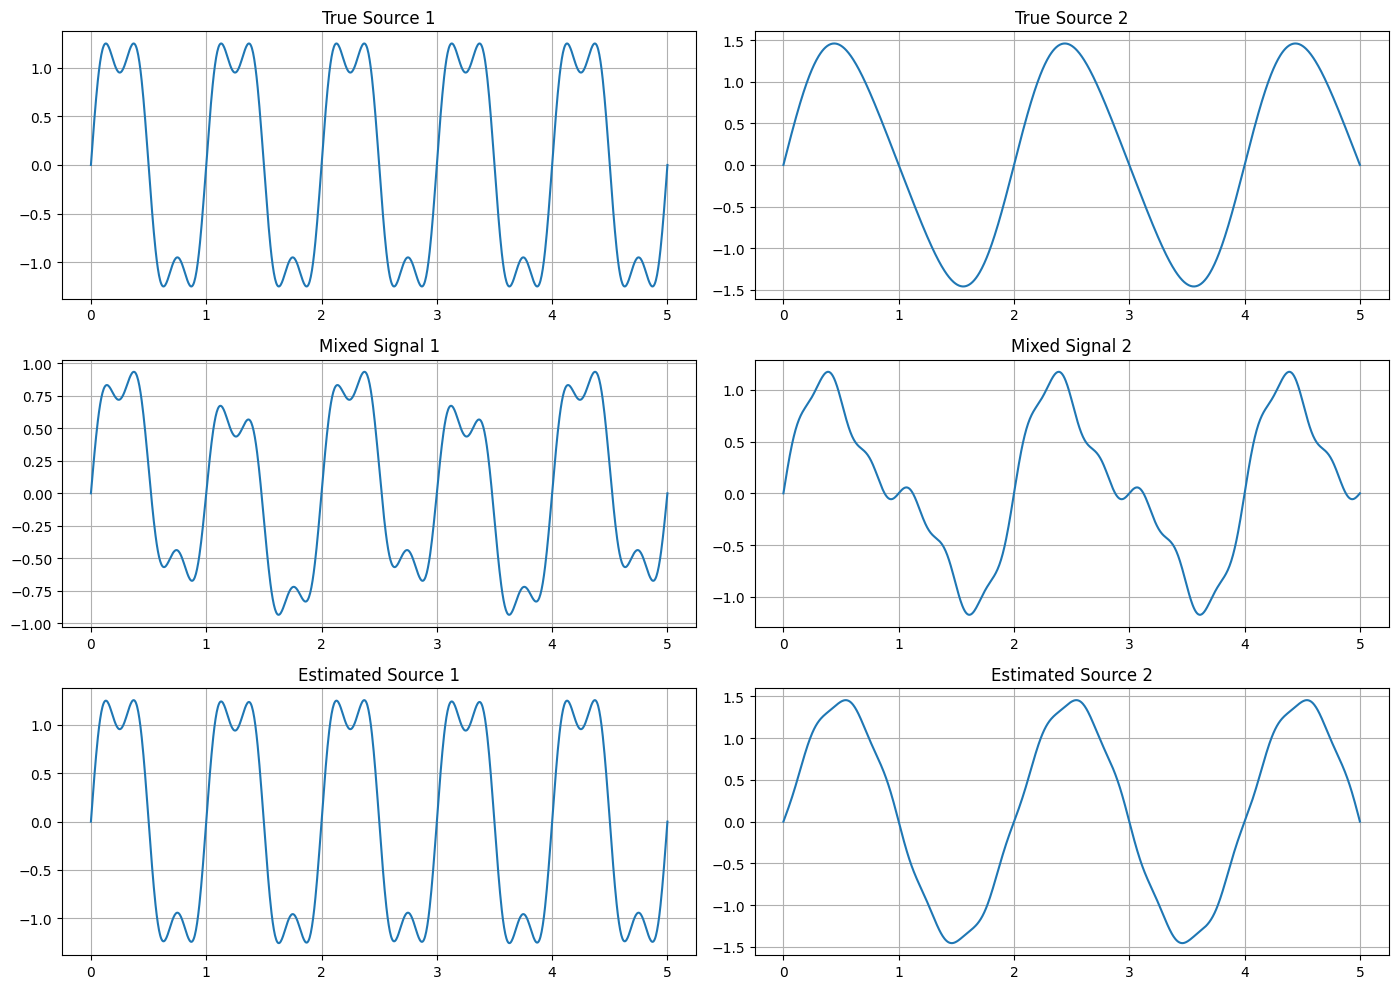

Correlation Source 1: 1.0000
Correlation Source 2: 0.9946


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la

def g(x, alpha=1.0):
    """ Contrast function: tanh """
    return np.tanh(alpha * x)

def gdot(x, alpha=1.0):
    """ Derivative of contrast function """
    gx = np.tanh(alpha * x)
    return alpha * (1 - gx**2)

def whiten_data(X, n_components=None):
    """
    Whiten the data using PCA whitening.
    Input: X of shape (n_features, n_samples)
    Output: X_white (n_components, n_samples), whitening matrix V
    """
    X = X - np.mean(X, axis=1, keepdims=True)
    n_features, n_samples = X.shape

    if n_components is None:
        n_components = n_features

    # Compute covariance
    C = np.dot(X, X.T) / n_samples

    # Eigenvalue decomposition
    d, U = la.eigh(C)

    # Sort in descending order
    idx = np.argsort(d)[::-1]
    d = d[idx]
    U = U[:, idx]

    # Keep only top n_components
    U = U[:, :n_components]
    d = d[:n_components]

    # Avoid division by zero
    d[d < 1e-10] = 1e-10

    # Whitening matrix: V = D^{-1/2} U^T
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    V = np.dot(D_inv_sqrt, U.T)

    X_white = np.dot(V, X)
    return X_white, V

def fastica(X, n_components=None, max_it=200, tol=1e-6, alpha=1.0, random_state=None):
    """
    FastICA algorithm (deflationary approach).

    Parameters:
    -----------
    X : array, shape (n_features, n_samples)
        Input data (should be whitened for best results, but function can whiten internally)
    n_components : int, optional
        Number of components to extract. If None, use min(n_features, n_samples)
    max_it : int
        Maximum number of iterations
    tol : float
        Tolerance for convergence
    alpha : float
        Parameter for contrast function
    random_state : int or None
        For reproducibility

    Returns:
    --------
    W : array, shape (n_components, n_features)
        Unmixing matrix (in whitened space)
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_features, n_samples = X.shape
    if n_components is None:
        n_components = min(n_features, n_samples)

    # Ensure n_components <= n_features
    n_components = min(n_components, n_features)

    # Preallocate W in whitened space: each row is a component (length = n_features_after_whitening)
    # But note: if X is already whitened, n_features = original n_components
    W = np.zeros((n_components, n_features))

    for i in range(n_components):
        # Random initial weight vector
        w = np.random.randn(n_features)
        w /= la.norm(w)

        lim = tol + 1
        it = 0

        while (lim > tol) and (it < max_it):
            # Project data: shape (n_samples,)
            wx = np.dot(w, X)  # shape (n_samples,)

            # Compute g(wx) and g'(wx)
            gw = g(wx, alpha)      # (n_samples,)
            gdw = gdot(wx, alpha)  # (n_samples,)

            # Update rule: w_new = E[X * g(w^T X)] - E[g'(w^T X)] * w
            w_new = (X @ gw) / n_samples - np.mean(gdw) * w

            # Orthogonalize with respect to previous components
            if i > 0:
                # Project out components 0 to i-1
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])

            # Normalize
            w_new /= la.norm(w_new)

            # Convergence: cosine similarity (angle)
            lim = 1 - np.abs(np.dot(w_new, w))
            w = w_new
            it += 1

        W[i, :] = w

    return W

# --- Verification with Proper Whitening ---
def verify_fastica():
    np.random.seed(42)
    n_samples = 1000
    t = np.linspace(0, 5, n_samples)

    # True sources
    s1 = np.sin(2 * np.pi * 1.0 * t) + 0.3 * np.sin(2 * np.pi * 3.0 * t)
    s2 = np.sin(2 * np.pi * 0.5 * t) + 0.1 * np.sin(2 * np.pi * 1.0 * t)
    S_true = np.vstack([s1, s2])  # (2, 1000)

    # Mixing matrix
    A_true = np.array([[0.8, 0.2],
                       [0.3, 0.9]])

    # Observed mixtures: X = A @ S
    X_obs = A_true @ S_true  # (2, 1000)

    # Step 1: Whiten the observed data
    X_white, V = whiten_data(X_obs, n_components=2)  # X_white: (2, 1000)

    # Step 2: Run FastICA on whitened data
    W_white = fastica(X_white, n_components=2, max_it=200, tol=1e-6, alpha=1.0, random_state=0)

    # Step 3: Reconstruct sources in whitened space
    S_est_white = W_white @ X_white  # (2, 1000)

    # Optional: Reconstruct full unmixing matrix in original space
    # Total unmixing: W_total = W_white @ V
    W_total = W_white @ V
    S_est_full = W_total @ X_obs

    # Normalize for comparison (ICA has scale ambiguity)
    S_est_full = S_est_full / np.std(S_est_full, axis=1, keepdims=True)
    S_true_norm = S_true / np.std(S_true, axis=1, keepdims=True)

    # Resolve permutation: match estimated to true via correlation
    corr00 = np.corrcoef(S_est_full[0], S_true_norm[0])[0,1]
    corr01 = np.corrcoef(S_est_full[0], S_true_norm[1])[0,1]

    if abs(corr01) > abs(corr00):
        # Swap rows
        S_est_full = S_est_full[::-1]
        corr01, corr00 = corr00, corr01

    # Plotting
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 2, 1)
    plt.plot(t, S_true_norm[0]); plt.title('True Source 1'); plt.grid(True)
    plt.subplot(3, 2, 2)
    plt.plot(t, S_true_norm[1]); plt.title('True Source 2'); plt.grid(True)

    plt.subplot(3, 2, 3)
    plt.plot(t, X_obs[0]); plt.title('Mixed Signal 1'); plt.grid(True)
    plt.subplot(3, 2, 4)
    plt.plot(t, X_obs[1]); plt.title('Mixed Signal 2'); plt.grid(True)

    plt.subplot(3, 2, 5)
    plt.plot(t, S_est_full[0]); plt.title('Estimated Source 1'); plt.grid(True)
    plt.subplot(3, 2, 6)
    plt.plot(t, S_est_full[1]); plt.title('Estimated Source 2'); plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Correlation Source 1: {np.corrcoef(S_est_full[0], S_true_norm[0])[0,1]:.4f}")
    print(f"Correlation Source 2: {np.corrcoef(S_est_full[1], S_true_norm[1])[0,1]:.4f}")

# Run verification
verify_fastica()